In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn import linear_model

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_ftir_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer2/spectrum_depths'][:]
        return depths

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def get_visible_insertion_spectrum_depths(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        depths = h5_file[f'{insertion_path}/spectrometer1/spectrum_depths'][:]
        return depths   

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

def get_spectrometer_name(file, session, spectrometer_number):
    with h5py.File(file, 'r') as h5_file:
        name = h5_file[session].attrs[f'spectrometer{spectrometer_number}'][:]
        return name

In [3]:
# read the total list of data files
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210604.csv')

# establish the file name for the first date
date='5/27/21'
bath_df = green_list_df.loc[green_list_df['date'] == date]
file_name = bath_df.iat[0, 0]
file = path_name + file_name

# since the wavelength vector does not change from session to session, here I get the first one.
calibration = bath_df['calibration'][120]
session = bath_df['session'][120]
cal_path = f'{session}/{calibration}'
vis_waves = get_visible_wavelength_vector(file, cal_path)

# this produces a list of strings of wavelength values
vis_columns = ["%.1f" % wave for wave in vis_waves]

In [4]:
# these are used to establish the first and last wavelengths that will be used in the analysis
vis_min_index = vis_columns.index('533.4')
vis_max_index = vis_columns.index('847.1')

vis_length = vis_max_index - vis_min_index

# here the actual data are read and compiled into a dataframe
all_absorbances = []
all_depths = []
df = pd.DataFrame()

dates = ['5/27/21', '6/4/21']

for date in dates: 
    bath_df = green_list_df.loc[green_list_df['date'] == date]
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name
    
    for index in bath_df.index.values:
        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        i_unique = bath_df['i_unique'][index]
        stop = date + " " + bath_df['target'][index][-3:]
        cal_path = f'{session}/{calibration}'
        insertion_path = f'{session}/{calibration}/{insertion}'
        vis_waves = get_visible_wavelength_vector(file, cal_path)[vis_min_index:vis_max_index]
        vis_columns = ["%.1f" % wave for wave in vis_waves]
        insertion_df = pd.DataFrame(get_visible_insertion_absorbances(file, insertion_path)[:, vis_min_index:vis_max_index], columns=vis_columns)
        insertion_df['depth'] = get_visible_insertion_spectrum_depths(file, insertion_path)
        insertion_df['session'] = session
        insertion_df['calibration'] = calibration
        insertion_df['insertion'] = insertion
        insertion_df['i_unique'] = i_unique
        insertion_df['stop'] = stop
        insertion_df['use'] = True
        df = pd.concat([df, insertion_df], ignore_index=True)

# this will be used to eliminate spectra that are invalid because they are from above the surface
df.loc[(df.depth < 5.0),'use'] = False

# this will be used to eliminate vegetation spectra
df.loc[(df['671.2']/df['735.7'] > 1.3), 'use'] = False

    
print(df.shape)

(1125, 248)


In [5]:
# these will be used as a surrogate for higher and lower SOC values.
# higher class numbers would be expected in general to have higher SOC content.

df['class_number'] = 1
df.loc[df['depth'] < 25, 'class_number'] = 2
df.loc[df['stop'] == '6/4/21 #10', 'class_number'] = 4
df.loc[df['stop'] == '6/4/21  #9', 'class_number'] = 4
df.loc[df['stop'] == '6/4/21  #8', 'class_number'] = 3
df.loc[df['stop'] == '5/27/21  #6', 'class_number'] = 3

In [6]:
# creates a dataframe containing only the "use" rows
df_use = df.loc[df['use']].copy()
print(df_use.shape)

(1006, 249)


In [7]:
X = df_use.iloc[:, :-8].copy()
X.shape

(1006, 241)

In [8]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))

In [9]:
pc_labels = []
for i in range(10):
    
    pc_label = f"PC{i + 1}"
    pc_labels.append(pc_label)

In [10]:
np.cumsum(pca.explained_variance_ratio_)

array([0.95419543, 0.98309974, 0.98890733, 0.98998063, 0.99046439,
       0.99083183, 0.9910655 , 0.99128159, 0.9914759 , 0.99165799])

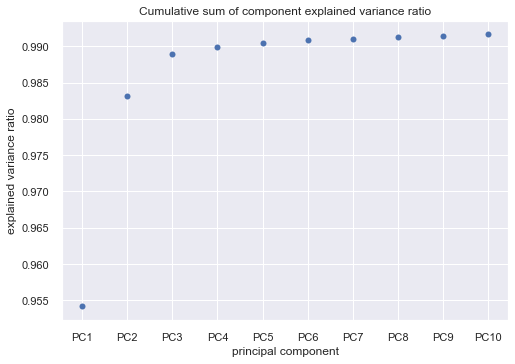

In [11]:
fig, ax = plt.subplots()
ax.set_title('Cumulative sum of component explained variance ratio')
ax.set_xlabel("principal component")
ax.set_ylabel("explained variance ratio")

ax.plot(pc_labels, np.cumsum(pca.explained_variance_ratio_), 'bo')
plt.show()
plt.close()

In [12]:
X_pca_df = pd.DataFrame(X_pca, columns=pc_labels)

In [13]:
df_info = df_use.iloc[:, -8:].copy().reset_index()

In [14]:
labels_dict = {1: "Lowest SOC",
              2: "Medium Low SOC",
              3: "Medium High SOC",
              4: "Highest SOC"}

colors_dict = {1: "tab:blue",
              2: "tab:green",
              3: "tab:orange",
              4: "tab:red"}

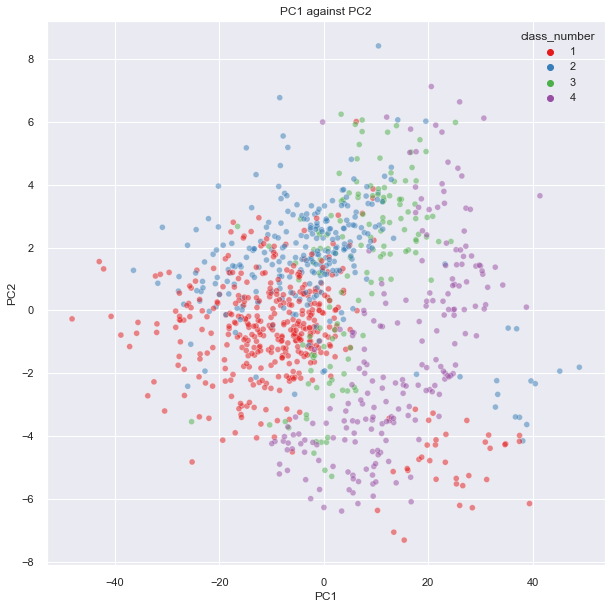

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("PC1 against PC2")
sns.scatterplot(x=X_pca_df['PC1'], y=X_pca_df['PC2'], 
                hue=df_info['class_number'], palette='Set1',
               alpha=0.5)
plt.show()
plt.close()

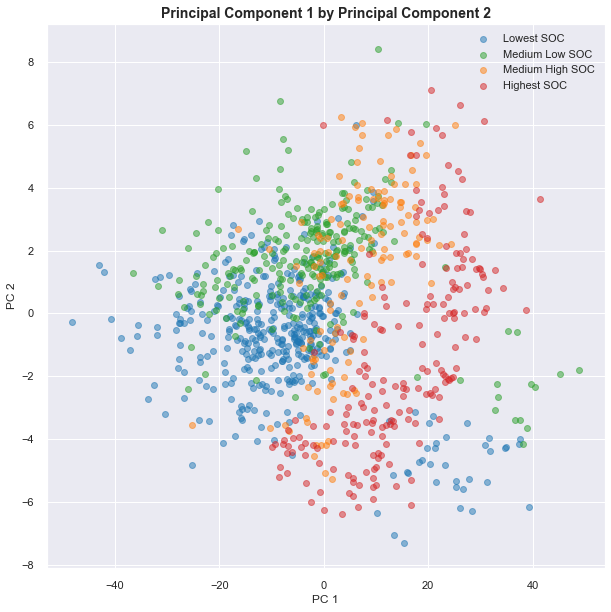

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Principal Component 1 by Principal Component 2", fontsize = 14, fontweight = 'bold')
ax.set_ylabel("PC 2")
ax.set_xlabel("PC 1")
for class_number in [1, 2, 3, 4]:
    plot_df = X_pca_df.loc[df_info['class_number'] == class_number]
    ax.scatter(plot_df['PC1'], plot_df['PC2'], 
               color=colors_dict[class_number],
               label=labels_dict[class_number],
               alpha=0.5
              )

ax.legend()
plt.show()
plt.close()

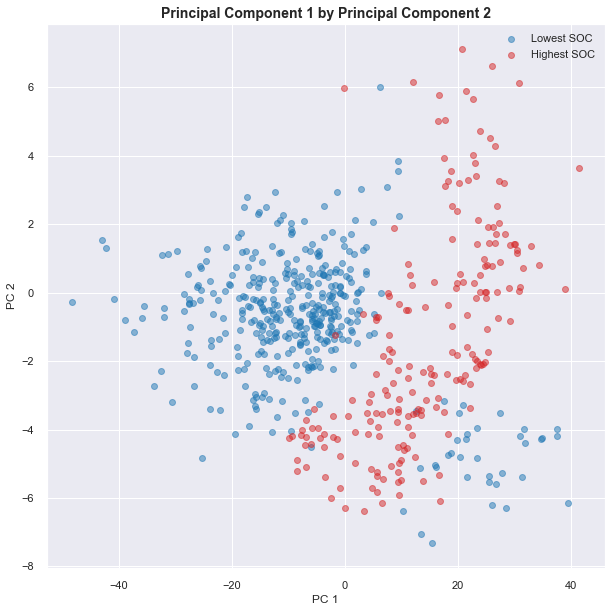

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Principal Component 1 by Principal Component 2", fontsize = 14, fontweight = 'bold')
ax.set_ylabel("PC 2")
ax.set_xlabel("PC 1")
for class_number in [1, 4]:
    plot_df = X_pca_df.loc[df_info['class_number'] == class_number]
    ax.scatter(plot_df['PC1'], plot_df['PC2'], 
               color=colors_dict[class_number],
               label=labels_dict[class_number],
               alpha=0.5
              )

ax.legend()
plt.show()
plt.close()